Exercise work consists of three parts. After each part, take the mini-exam available in Moodle. The questions concern the exercise so read the instructions carefully and make sure you remember to cover all given tasks. <br>
After the deadline of each mini-exam, example results will be published. This helps you to move to the next part. However, take into account that the deadlines are thus strict, no extensions will be granted! <br>
Two exam points can be acquired from each mini-exam. All three parts of the exercise are compulsory. Completed exercise work from previous years does not apply for this course.

**Deadlines for the mini-exams:**
- Part 1: Fri 9.2.2024 at 23:59
- Part 2: Fri 23.2024 at 23:59
- Part 3: Fri 8.3.2024 at 23:59

**If you encounter problems, Google first and if you can’t find an answer, ask for help**
- Moodle area for questions
- pekavir@utu.fi

**Grading**

The exercise covers a part of the grading in this course. The course exam has 5 questions, 6 points of each. Exercise gives at maximum 6 points, i.e. the total score is 36 points.

# Part 1

Write a proper introductory chapter for your report:
<br>
- Explain the task and the objectives
- Describe, what kind of data were used? Where did it originate? Give the correct reference. Explain shortly, how the data has been prepared in the original article. Explain, how you deployed the data
- Report shortly the process used in this task (preprocessing, feature derivation, methods, training, evaluation)
- Describe the results

# Part 2

# Part 3

In [58]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import cv2 as cv
# import glob, os
# import itertools
# from random import sample
# from random import seed
# from scipy.stats import skew
# from scipy.stats import kurtosis
# from scipy.stats import entropy
# import scipy.stats
# from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import time

## Performance estimation

### Random Forest

Let's estimate the performance of each model using nested cross-validation. <br>
Again, we'll use 5-fold repeated cross validation with 3 repetitions and the same parameter ranges as in Part 2 for the inner loop. <br>
For the outer loop we'll use 10-fold Stratified Kfold cross-validation.

Study the following implementation of performance estimation for Random Forest model. <br>
**You do not need to run the cell below, you can import the results and start from there.** <br>

In [ ]:
df = pd.read_parquet('../training_data/rice_feature_data.parquet')

feats = ['mean_y', 'var_y', 'skew_y', 'kurt_y',
         'mean_cr', 'var_cr', 'skew_cr', 'kurt_cr',
         'mean_cb', 'var_cb', 'skew_cb', 'kurt_cb',
         'major_axis_length', 'minor_axis_length',
         'area', 'perimeter',
         'equivalent_diameter', 'compactness',
         'shape_factor1', 'shape_factor2']

# Z-Score using pandas
for feat in feats:
    df['{}_Z'.format(feat)] = (df[feat] - df[feat].mean()) / df[feat].std()

# Z-scored feature names
feats_Z = [feat + '_Z' for feat in feats]

y = df['class']
X = df[feats_Z]

kf_outer = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
kf_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

n_estimators = range(100, 350, 50) 
max_features = ['sqrt', 'log2', None]
bootstrap = [True, False]

parameters={
    'n_estimators': n_estimators,
    'max_features': max_features,
    'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state=20)

results = []

start_time = time.time()

for fold, (train_index, test_index) in enumerate(kf_outer.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # temporary dataframe for saving the results
    temp_res = df.iloc[test_index].copy()
    temp_res['fold'] = [fold] * temp_res.shape[0]
        
    # select the best model
    gscv = GridSearchCV(rf, parameters, cv=kf_inner, return_train_score=False, n_jobs=-1)
    gscv.fit(X_train, y_train)
    
    # use the selected model to predict the classes for the test data
    temp_res['pred_class'] = gscv.predict(X_test)
    
    # save the best hyperparameter combination
    temp_res['best_params'] = [gscv.best_params_] * temp_res.shape[0]
    
    results.append(temp_res)

results = pd.concat(results, axis=0)
results['accuracy'] = results.apply(lambda i: 1 if i['class'] == i['pred_class'] else 0, axis=1)

results.index.name = 'orig_index'
# sort the results in the same order as in df
results = results.sort_values('orig_index').reset_index(drop=True)
results.to_parquet('../results/rf_results.parquet')
    
print("--- %s seconds ---" % (time.time() - start_time))

Save the supplied (can be found from Moodle) rf_results.parquet-file in a folder named "results".

In [23]:
# start from here!
results = pd.read_parquet('../results/rf_results.parquet')
results.head()

,mean_y,var_y,skew_y,kurt_y,mean_cr,var_cr,skew_cr,kurt_cr,mean_cb,var_cb,...,area_Z,perimeter_Z,equivalent_diameter_Z,compactness_Z,shape_factor1_Z,shape_factor2_Z,fold,pred_class,best_params,accuracy
0,218.428552,196.303077,-0.338409,-0.504973,127.368889,0.233079,0.547052,-1.690834,130.752593,1.983907,...,-0.182208,-0.447928,-0.113246,0.653603,-0.546681,0.461055,1,Arb,"{'bootstrap': False, 'max_features': 'sqrt', '...",1
1,206.205057,84.868804,1.129581,2.096088,127.158176,0.133157,1.873486,1.509951,130.197674,0.726706,...,-0.860789,-1.160999,-0.927399,0.446620,0.092642,1.045635,1,Arb,"{'bootstrap': False, 'max_features': 'sqrt', '...",1
2,215.034675,366.375486,0.051958,-0.814078,128.245927,0.185447,1.179993,-0.607617,129.834424,0.940277,...,-0.262414,-0.393699,-0.203251,0.352478,-0.334549,0.262486,4,Arb,"{'bootstrap': False, 'max_features': 'sqrt', '...",1
3,203.853259,214.463028,-0.487579,-0.702229,127.098179,0.088540,2.700806,5.294351,130.877276,1.362875,...,-0.130909,-0.393114,-0.056426,0.498123,-0.497113,0.217142,3,Arb,"{'bootstrap': False, 'max_features': 'sqrt', '...",1
4,226.097925,248.915262,-0.806989,0.882970,128.265342,0.194935,1.062969,-0.870097,129.471783,1.972111,...,-0.359832,-0.393114,-0.314572,0.138864,-0.139084,0.255664,6,Arb,"{'bootstrap': False, 'max_features': 'sqrt', '...",1


In [39]:
# extract rf columns
results_rf = results.iloc[:, -4:]

Answer the questions/tasks: <br>
 - Which parameter combination is selected the best most often?
 - Calculate the mean accuracy of each fold and the mean accuracy over all folds
 - Calculate the confusion matrix over all samples

In [28]:
# amount of appearances for each paremeter combination
results_rf['best_params'].value_counts()

best_params
{'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 100}    200
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 150}     100
{'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 150}     50
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 300}      50
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}      50
{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 250}      50
Name: count, dtype: int64

<small><i>Parameter combination {'bootstrap': False, 'max_features': 'sqrt', 'n_estimators': 100} is selected most often - in 4 of the 10 folds.</i></small>

In [31]:
# mean accuracy of each fold
results_rf.groupby(by='fold')['accuracy'].mean()

fold
0    0.98
1    1.00
2    1.00
3    1.00
4    1.00
5    1.00
6    0.96
7    1.00
8    1.00
9    1.00
Name: accuracy, dtype: float64

In [35]:
# accuracy over all folds
results_rf['accuracy'].mean()

0.994

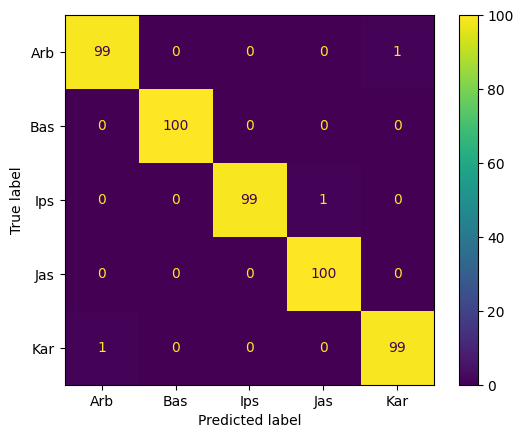

In [54]:
# confusion matrix over all samples
cm = confusion_matrix(results['class'], results['pred_class'], labels=['Arb', 'Bas', 'Ips', 'Jas', 'Kar'])

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Arb', 'Bas', 'Ips', 'Jas', 'Kar'])
disp.plot()
plt.show()

Here's another way to implement nested cross-validation which uses *cross_val_predict* function from scikit-learn.<br>
Modify it to make the perfomance estimation for MLP and SVM (again, use the paramater ranges given in the Part 2).<br>
For both models:
 - Calculate the accuracy over all samples
 - Show the confusion matrix (you can combine all samples in one confusion matrix as all folds are stratified and include the same number of samples)

Compare the three models. Which one performs the best?

In [3]:
feats_Z = ['mean_y_Z', 'var_y_Z',
 'skew_y_Z', 'kurt_y_Z',
 'mean_cr_Z', 'var_cr_Z',
 'skew_cr_Z', 'kurt_cr_Z',
 'mean_cb_Z', 'var_cb_Z',
 'skew_cb_Z', 'kurt_cb_Z',
 'major_axis_length_Z',
 'minor_axis_length_Z',
 'area_Z', 'perimeter_Z',
 'equivalent_diameter_Z',
 'compactness_Z',
 'shape_factor1_Z',
 'shape_factor2_Z']

In [4]:
# another way
y = results['class']
X = results[feats_Z]

rf = RandomForestClassifier(random_state=20)

kf_outer = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
kf_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

n_estimators = range(100, 350, 50) 
max_features = ['sqrt', 'log2', None]
bootstrap = [True, False]

parameters={
    'n_estimators': n_estimators,
    'max_features': max_features,
    'bootstrap': bootstrap}

gscv = GridSearchCV(rf, parameters, cv=kf_inner, return_train_score=False, n_jobs=-1)
nested_pred = cross_val_predict(gscv, X, y, cv=kf_outer)

In [59]:
# accuracy of random forest model
rf_accuracy = accuracy_score(results['class'], nested_pred)
print(f"Accuracy of random forest classifier: {rf_accuracy}")

Accuracy of random forest classifier: 0.994


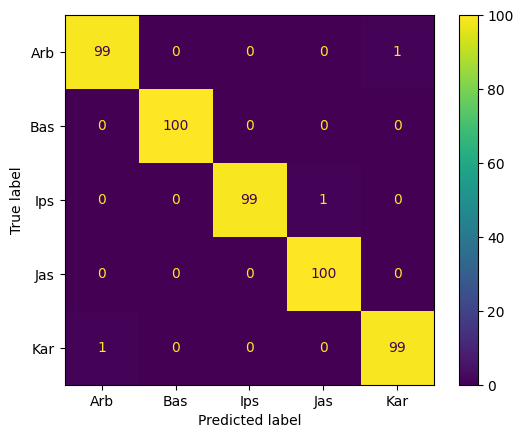

In [60]:
# confusion matrix over all samples
cm = confusion_matrix(results['class'], nested_pred, labels=['Arb', 'Bas', 'Ips', 'Jas', 'Kar'])

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Arb', 'Bas', 'Ips', 'Jas', 'Kar'])
disp.plot()
plt.show()

In [62]:
# MLP
y = results['class']
X = results[feats_Z]

kf_outer = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
kf_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

# parameter grid
param_grid_mlp = {
    'hidden_layer_sizes': range(15, 41, 5),
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'validation_fraction': [0.1, 0.3],
    'alpha': [0.01, 0.1, 1]
}

# classifier model
mlp = MLPClassifier(random_state=523834)

gscv = GridSearchCV(mlp, param_grid_mlp, cv=kf_inner, return_train_score=False, n_jobs=-1)
mlp_nested_pred = cross_val_predict(gscv, X, y, cv=kf_outer)

c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Opti

In [63]:
# accuracy of MLP model
mlp_accuracy = accuracy_score(results['class'], mlp_nested_pred)
print(f"Accuracy of MLP classifier: {mlp_accuracy}")

Accuracy of MLP classifier: 0.994


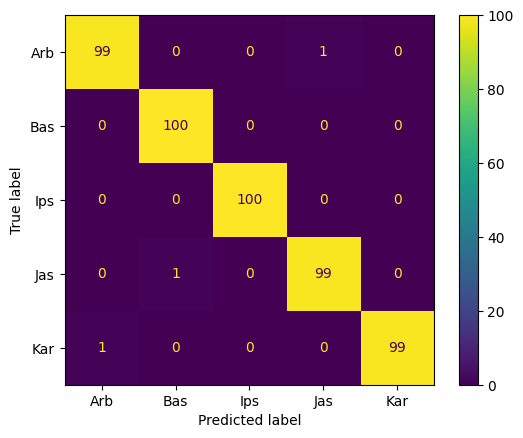

In [64]:
# confusion matrix of MLP model over all samples
cm = confusion_matrix(results['class'], mlp_nested_pred, labels=['Arb', 'Bas', 'Ips', 'Jas', 'Kar'])

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Arb', 'Bas', 'Ips', 'Jas', 'Kar'])
disp.plot()
plt.show()

Examine the confusion matrices. Were the acquired results as expected? Why?

In [65]:
# SVM
y = results['class']
X = results[feats_Z]

kf_outer = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
kf_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

# parameter grid
param_grid_svm = {
    'gamma': ['scale', 'auto'],
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly']
}

# classifier model
svc = SVC(random_state=523834)

gscv = GridSearchCV(svc, param_grid_svm, cv=kf_inner, return_train_score=False, n_jobs=-1)
svc_nested_pred = cross_val_predict(gscv, X, y, cv=kf_outer)

In [66]:
# accuracy of SVM model
svm_accuracy = accuracy_score(results['class'], svc_nested_pred)
print(f"Accuracy of MLP classifier: {svm_accuracy}")

Accuracy of MLP classifier: 0.998


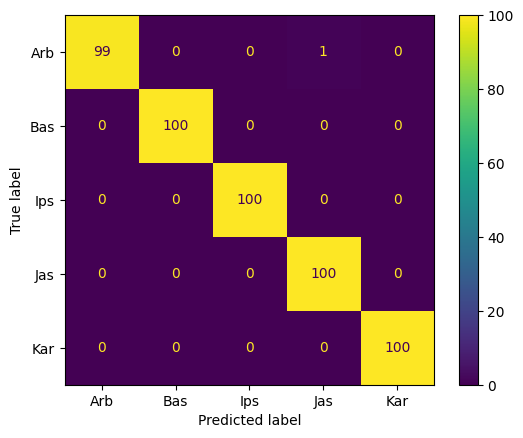

In [67]:
# confusion matrix of MLP model over all samples
cm = confusion_matrix(results['class'], svc_nested_pred, labels=['Arb', 'Bas', 'Ips', 'Jas', 'Kar'])

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Arb', 'Bas', 'Ips', 'Jas', 'Kar'])
disp.plot()
plt.show()

SVM performs the best, although all models perform quite well.

## Discussion

Discuss you results:

- Ponder the limitations and generalization of the models. How well will they perform for data outside this data set? Explain.
- Compare your results with the original article. Are they comparable? 
- Ponder applications for these kind of models, who could benefit from them? What would be interesting to study more on this area?

## Reflection

Reflect your work:

- Did you have any (mis)conceptions which changed while doing this work? 
- What did you learn?
- What was difficult?
- In which aspects of work did you succeed well?
- How could you improve you working process?
- How can you deploy the learnings from this exercise in future?